In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import KFold

import os
import datetime
import itertools

# ログ出力用の関数
def printTime(tag):
    print(tag + ':', datetime.datetime.now())

printTime('Inputファイルを表示')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Inputファイルを表示: 2020-01-18 12:31:14.073008
/kaggle/input/test.csv
/kaggle/input/data_description.txt
/kaggle/input/train.csv
/kaggle/input/.ipynb_checkpoints/test-checkpoint.csv


#### 学習データの読み込み

In [28]:
train = pd.read_csv('/kaggle/input/train.csv')
test = pd.read_csv('/kaggle/input/test.csv')

# 学習データを特徴量と目的変数に分ける
train_x = train.drop(['SalePrice'], axis=1)
train_y = train['SalePrice']

# テストデータは特徴量のみなので、そのままでよい
test_x = test.copy()


#### 学習データの分析

In [29]:
# SalePriceの平均や標準偏差、最大値、最小値、最頻値などの要約統計量を表示
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

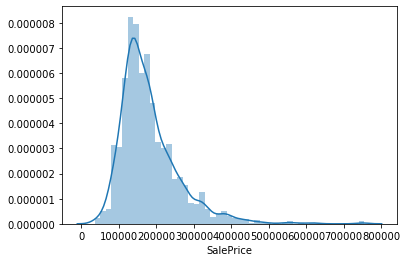

In [30]:
# SalePriceのヒストグラムを表示
sns.distplot(train['SalePrice'])

Id
MSSubClass
LotFrontage
LotArea
OverallQual
OverallCond
YearBuilt
YearRemodAdd
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd
Fireplaces
GarageYrBlt
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
MoSold
YrSold
SalePrice


/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:1675: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


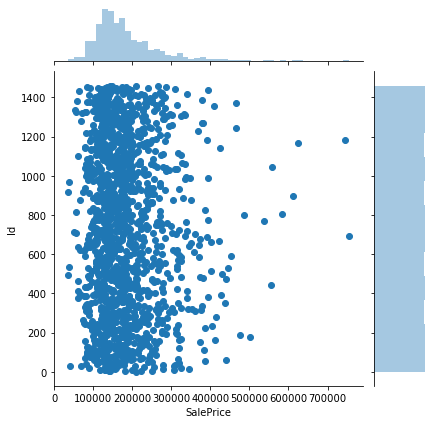

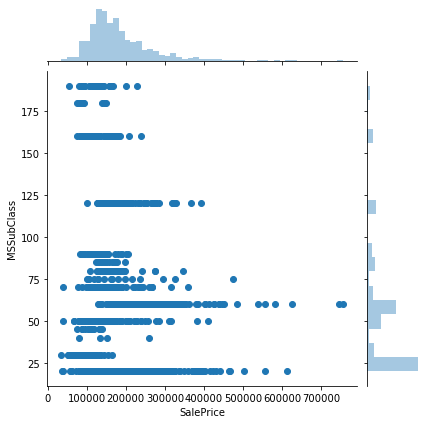

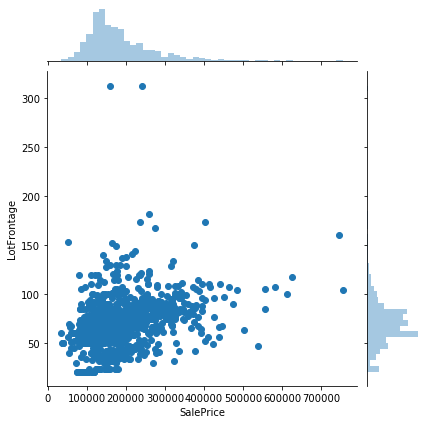

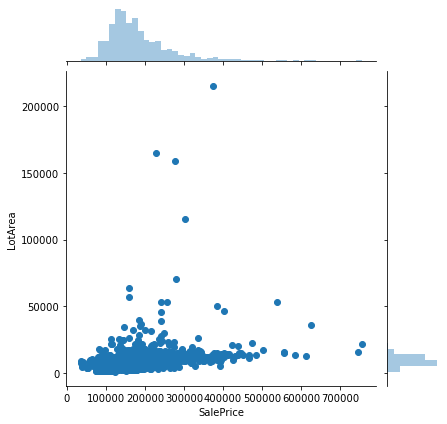

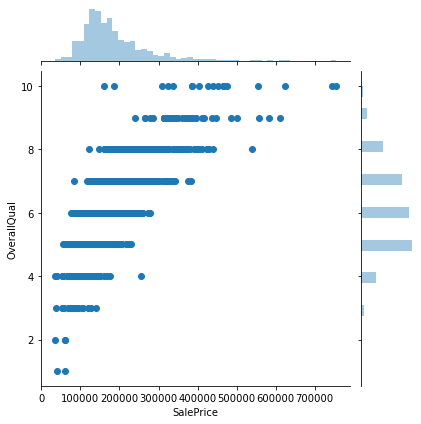

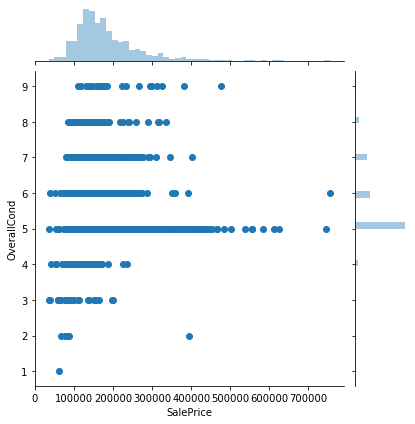

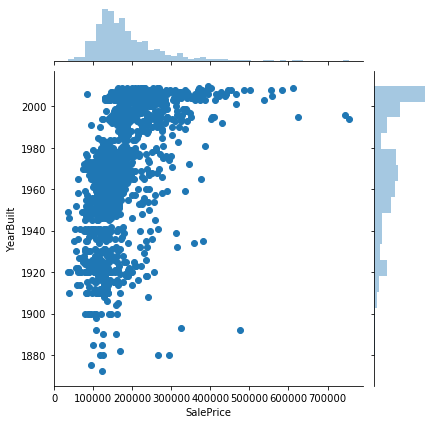

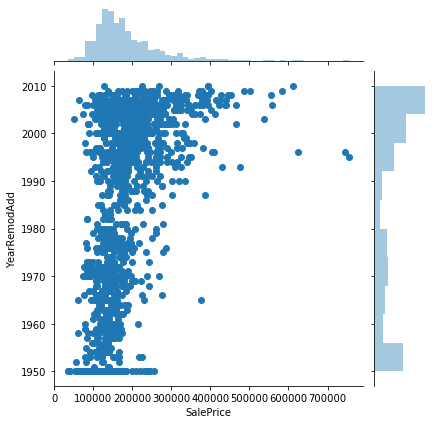

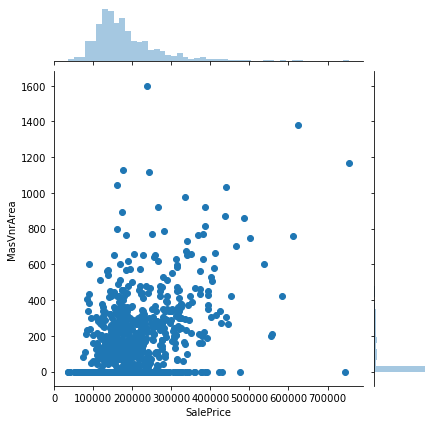

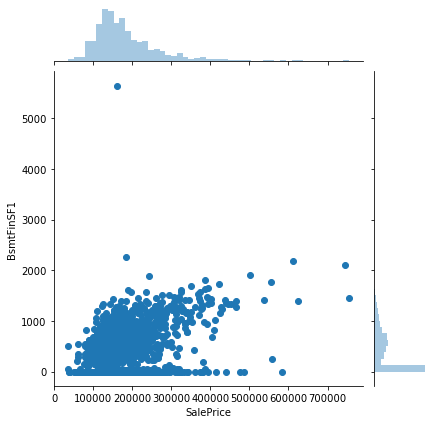

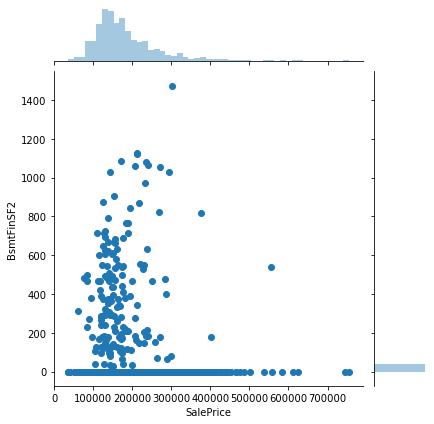

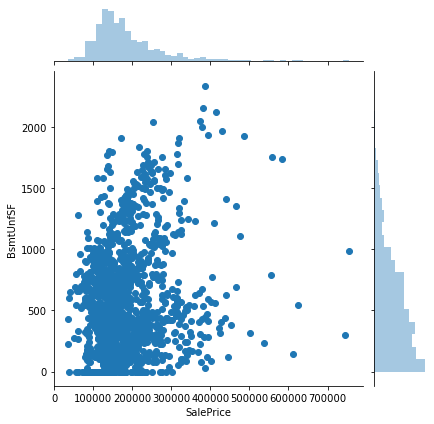

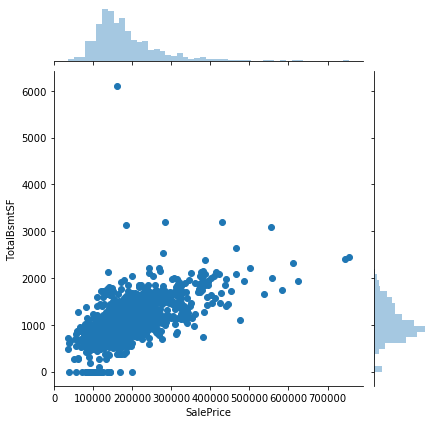

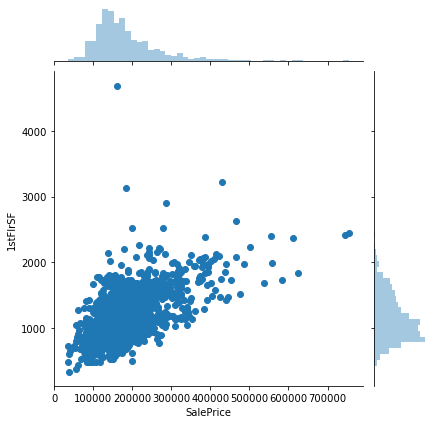

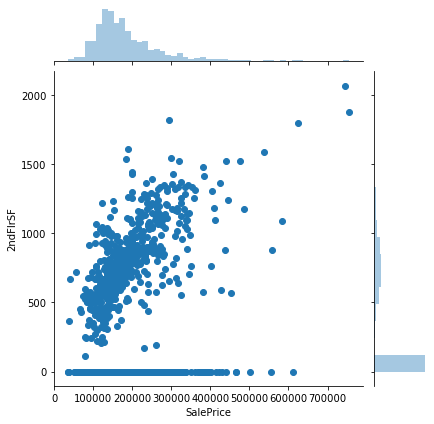

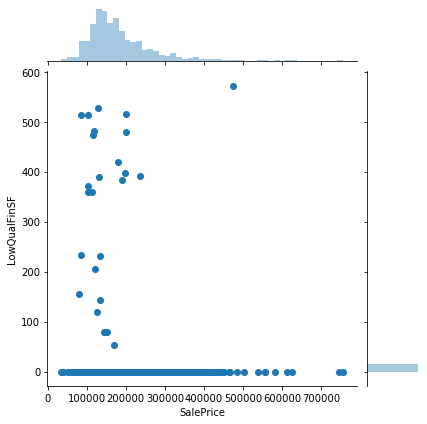

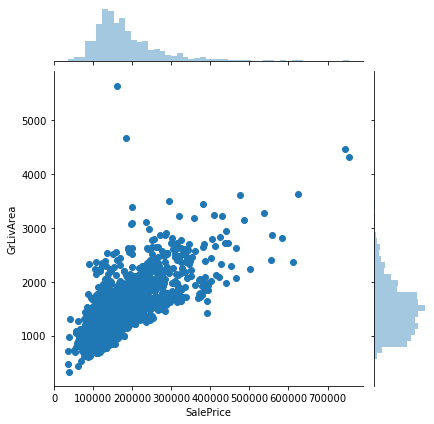

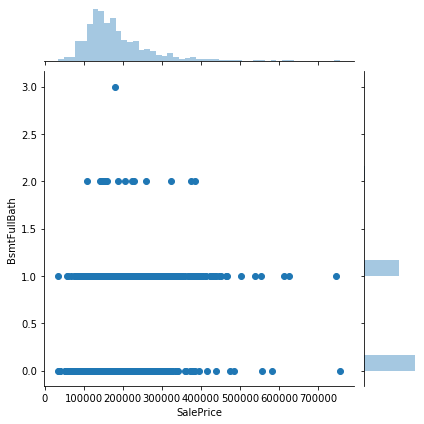

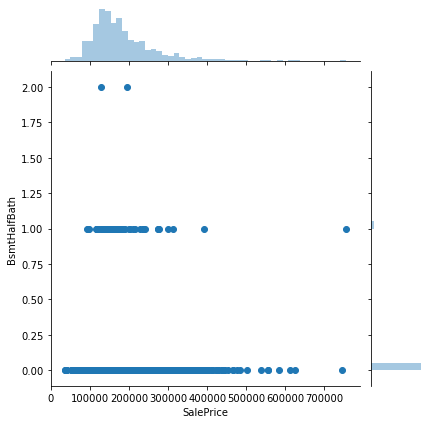

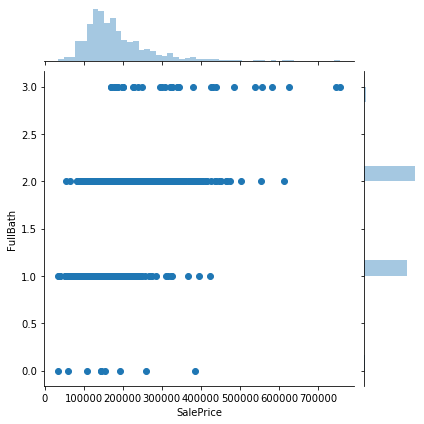

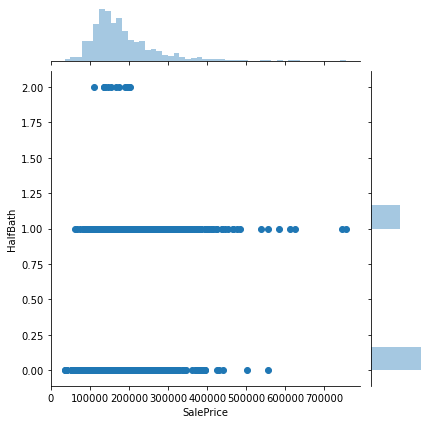

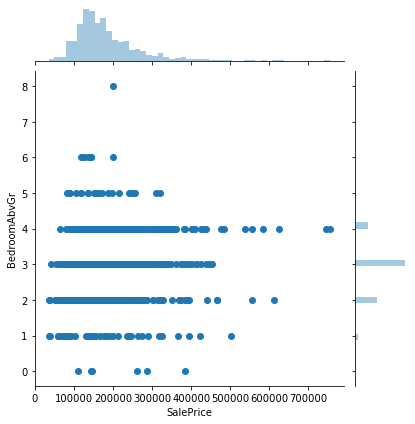

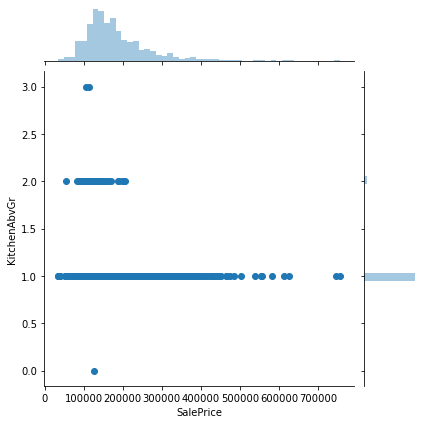

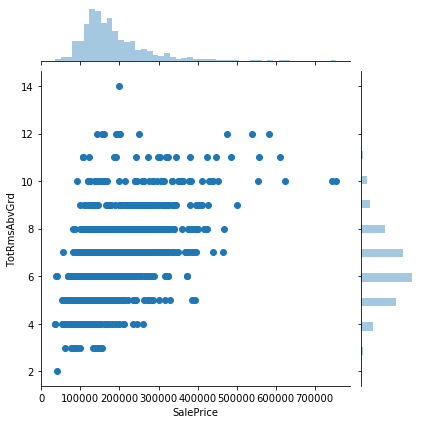

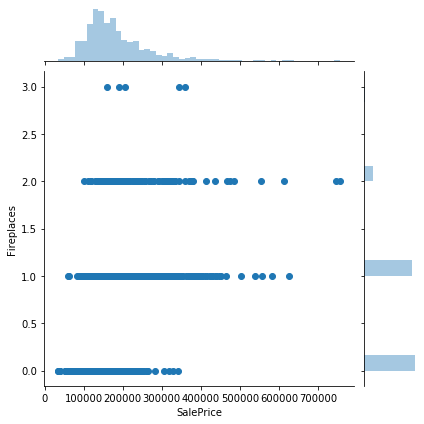

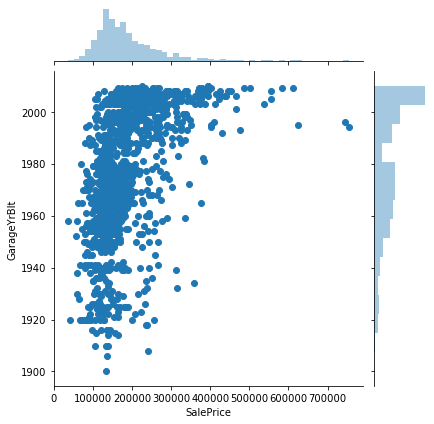

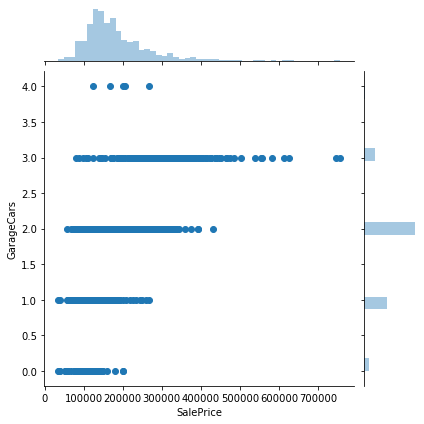

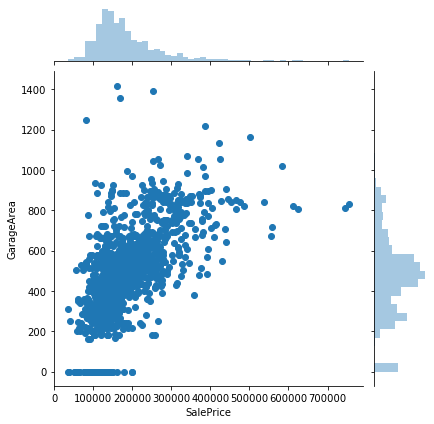

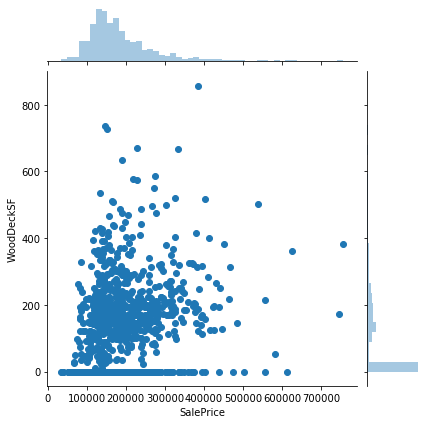

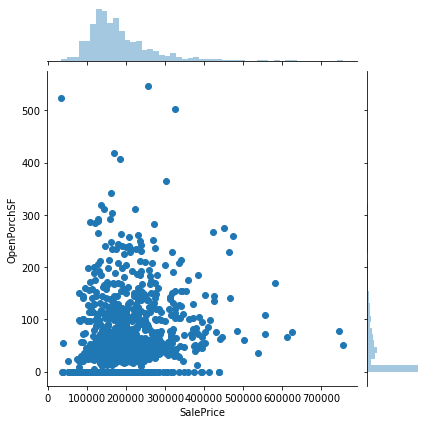

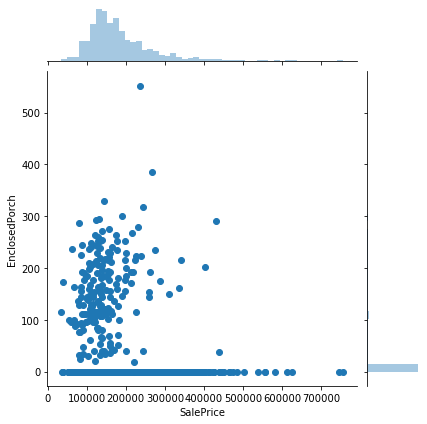

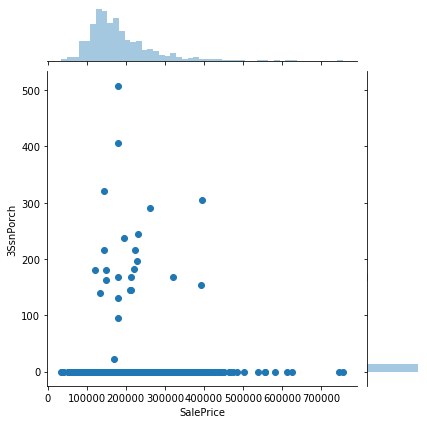

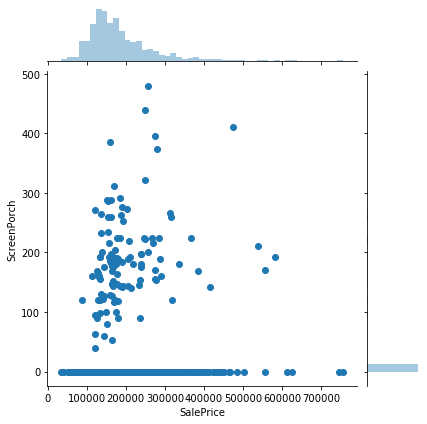

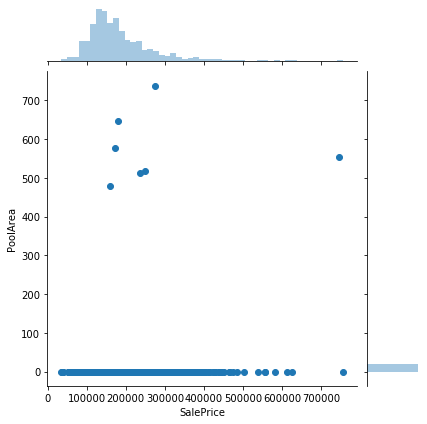

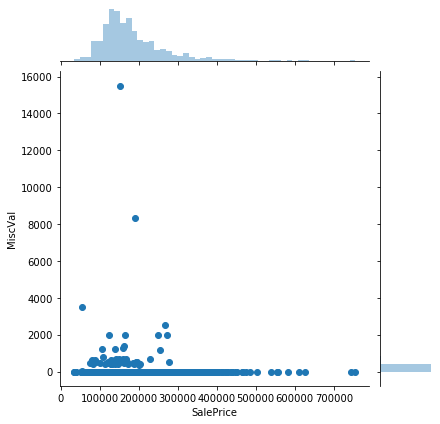

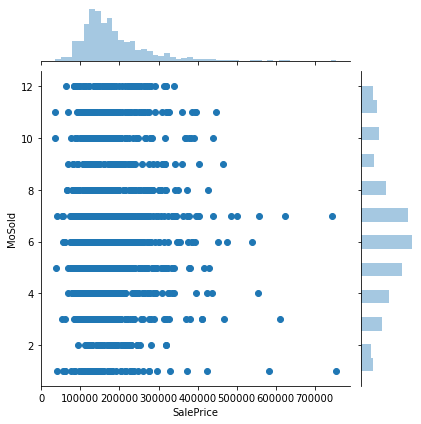

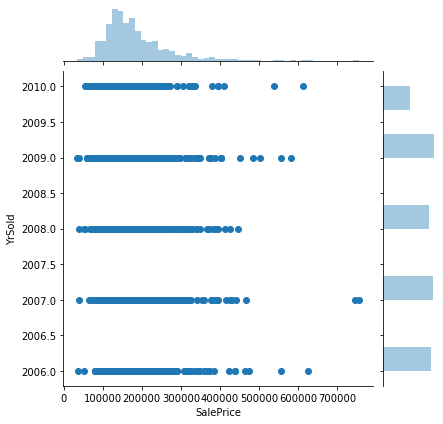

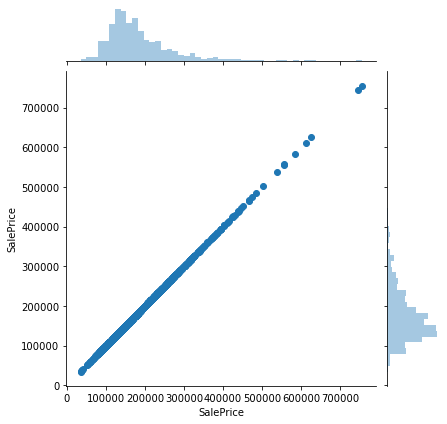

In [31]:
# SalePriceと数値データの散布図を表示
# 学習用データから数値データの列名を取得
train_num = train.select_dtypes(include='number').columns.values

for target in train_num:
    print(target)

# 数値データの分、散布図をプロット
for target in train_num:
    sns.jointplot(train['SalePrice'], train[target])

 #### 特徴量作成

In [32]:
# 解析対象とする列を設定
targets = ['OverallQual', 
           'TotalBsmtSF', 
           '1stFlrSF', 
           '2ndFlrSF', 
           'GrLivArea', 
           'GarageArea']

# 解析対象列のみを抽出
train_x = train_x.loc[:,targets]
test_x = test_x.loc[:,targets]


#### モデル作成

In [36]:
printTime('モデルの作成開始')

# モデルの作成および学習データを与えての学習
model = XGBClassifier(n_estimators=20, random_state=71, 
                      max_depth=5, min_child_weight=1.0)
model.fit(train_x, train_y)

# テストデータの予測値を出力する
pred = model.predict(test_x)

# 提出用ファイルの作成
submission = pd.DataFrame({'Id': test['Id'], 'SalePrice': pred})
submission.to_csv('/kaggle/output/submission_first.csv', index=False)

printTime('モデルの作成終了')

モデルの作成開始: 2020-01-18 12:39:29.450053
モデルの作成終了: 2020-01-18 12:39:45.834780


#### バリデーション

In [34]:
printTime('バリデーション開始')

# 各foldのスコアを保存するリスト
scores_rmse = []

# クロスバリデーションを行う
# 学習データを4つに分割し、うち1つをバリデーションデータとすることを、バリデーションデータを変えて繰り返す
kf = KFold(n_splits=4, shuffle=True, random_state=71)
for tr_idx, va_idx in kf.split(train_x):
    
    # 学習データを学習データとバリデーションデータに分ける
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

    # モデルの学習を行う
    model = XGBClassifier(n_estimators=20, random_state=71)
    model.fit(tr_x, tr_y)

    # バリデーションデータの予測値を出力する
    va_pred = model.predict(va_x)

    # バリデーションデータでのスコア(真の値の対数と予測値の対数の二乗平均平方根誤差 (RMSE))を計算する
    rmse = np.sqrt(mean_squared_error(np.log(va_y), np.log(va_pred)))

    # そのfoldのスコアを保存する
    scores_rmse.append(rmse)

# 各foldのスコアの平均を出力する
rmse = np.mean(scores_rmse)
print(f'RMSE: {rmse:.5f}')

printTime('バリデーション終了')

バリデーション開始: 2020-01-18 12:32:00.779756
RMSE: 0.24311
バリデーション終了: 2020-01-18 12:32:26.776398


#### モデルチューニング

In [35]:
printTime('モデルチューニング開始')

# チューニング候補とするパラメータを準備する
param_space = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1.0, 2.0, 4.0]
}

# 探索するハイパーパラメータの組み合わせ
param_combinations = itertools.product(param_space['max_depth'], param_space['min_child_weight'])

# 各パラメータの組み合わせ、それに対するスコアを保存するリスト
params = []
scores = []

# 各パラメータの組み合わせごとに、クロスバリデーションで評価を行う
for max_depth, min_child_weight in param_combinations:

    score_folds = []
    # クロスバリデーションを行う
    # 学習データを4つに分割し、うち1つをバリデーションデータとすることを、バリデーションデータを変えて繰り返す
    kf = KFold(n_splits=4, shuffle=True, random_state=123456)
    for tr_idx, va_idx in kf.split(train_x):
        # 学習データを学習データとバリデーションデータに分ける
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

        # モデルの学習を行う
        model = XGBClassifier(n_estimators=20, random_state=71,
                              max_depth=max_depth, min_child_weight=min_child_weight)
        model.fit(tr_x, tr_y)

        # バリデーションデータでのスコアを計算し、保存する
        va_pred = model.predict(va_x)
        rmse = np.sqrt(mean_squared_error(np.log(va_y), np.log(va_pred)))
        score_folds.append(rmse)

    # 各foldのスコアを平均する
    score_mean = np.mean(score_folds)

    # パラメータの組み合わせ、それに対するスコアを保存する
    params.append((max_depth, min_child_weight))
    scores.append(score_mean)

# 最もスコアが良いものをベストなパラメータとする
best_idx = np.argsort(scores)[0]
best_param = params[best_idx]
print(f'max_depth: {best_param[0]}, min_child_weight: {best_param[1]}')

printTime('モデルチューニング終了')

モデルチューニング開始: 2020-01-18 12:32:26.791452
max_depth: 5, min_child_weight: 1.0
モデルチューニング終了: 2020-01-18 12:36:01.312474
